# **Contents**
- [1. Introduction](#1.-Introduction)
- [2. Analysis](#2.-Analysis)
- [4. References](#4.-References)
- [5. See Also](#5.-See-Also)

# 1. Introduction
   A time series is a set of data points gathered and organized in chronological order. Each data point in a time series usually represents a value of an instrument at a specific moment in time. Time series are widely utilized in various fields such as economics, finance, climate studies, asset management, and scientific research to analyze and forecast future trends.
    


# 2. Analysis

In this notebook, i will be using ....

## 2. 1. Let's check the data

First of all, let's read it from the input and put them in a list.

In [11]:
# !pip install minisom
# !pip install tslearn

In [12]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [13]:
directory = "D:\\Do_an_2\\Project_2\\data_pro"


mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df = df.loc[:,["date","view"]]
        df.set_index("date",inplace=True)
        # set the date columns as index
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

Let's check how many series we have.

In [14]:
print(len(namesofMySeries))

17


In [15]:
for name_series in namesofMySeries:
    print(name_series)

aa_004
aa_067
aa_082
aa_199
aa_322
aa_328
aa_336
aa_337
aa_448
aa_456
aa_572
aa_595
aa_736
aa_910
aa_914
aa_965
aa_977


In [16]:
for df in mySeries:
    print(df.describe())

             view
count  472.000000
mean    50.866525
std     18.341685
min      4.000000
25%     38.000000
50%     47.000000
75%     62.000000
max    132.000000
             view
count  470.000000
mean    86.187234
std     24.455238
min      4.000000
25%     71.000000
50%     84.000000
75%    101.750000
max    162.000000
             view
count  472.000000
mean   153.411017
std     27.297926
min     72.000000
25%    135.000000
50%    151.000000
75%    170.000000
max    242.000000
             view
count  471.000000
mean   267.615711
std    132.637560
min      1.000000
25%    143.000000
50%    274.000000
75%    380.000000
max    641.000000
             view
count  472.000000
mean   236.288136
std     58.353284
min     86.000000
25%    193.750000
50%    230.000000
75%    270.250000
max    648.000000
             view
count  459.000000
mean    34.167756
std     18.731502
min      6.000000
25%     20.000000
50%     30.000000
75%     44.000000
max    115.000000
             view
count  464

So, for 17 series let's create a 5 by 4 grid which will be resulted in 20 slots and fill it with the plot of our series.

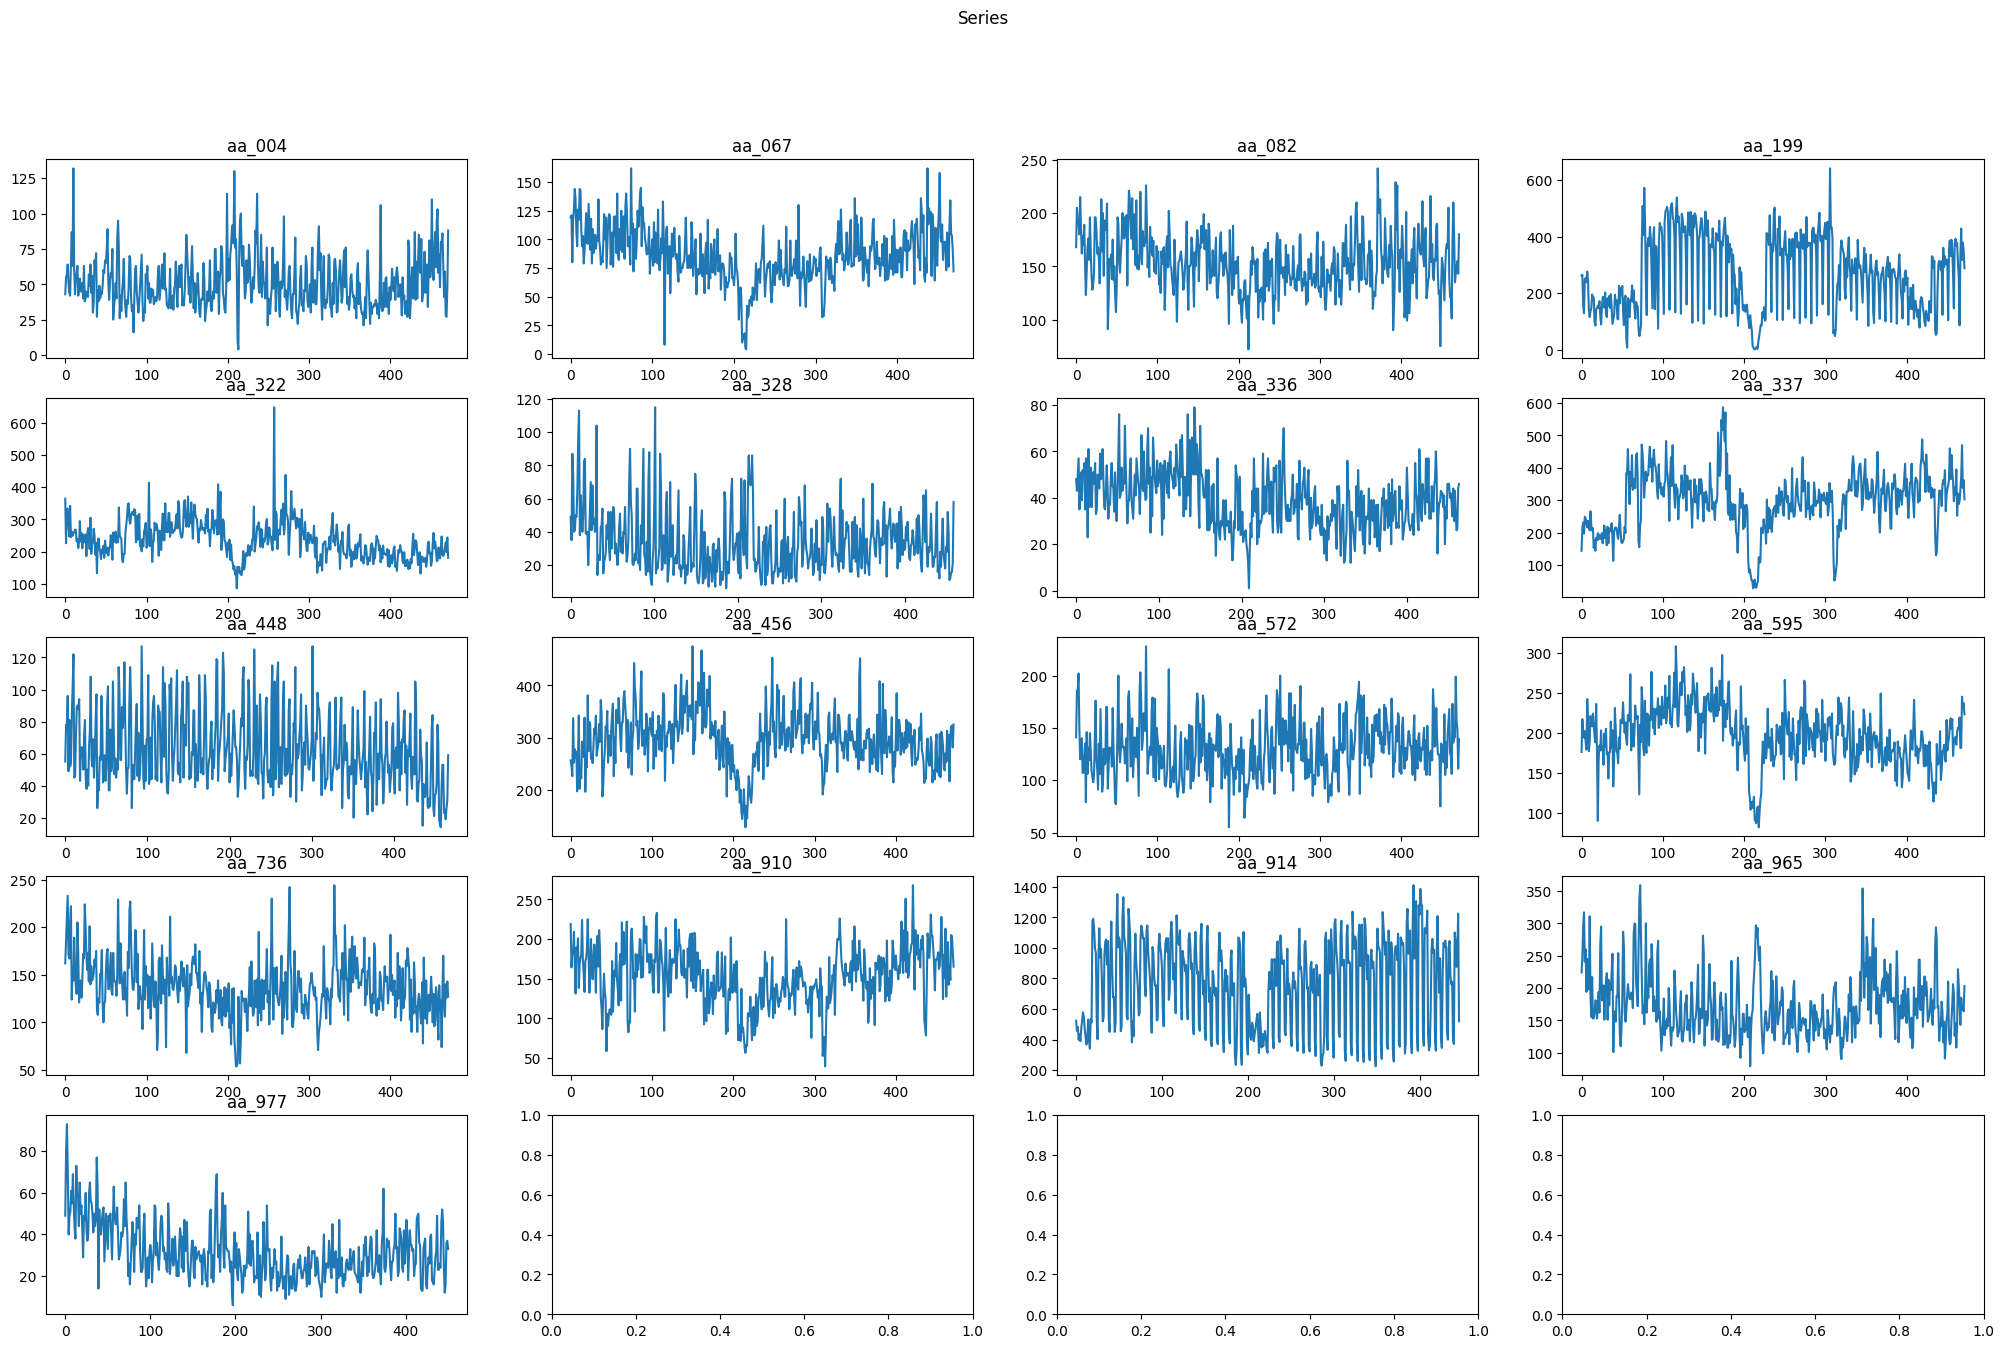

In [17]:
fig, axs = plt.subplots(5,4,figsize=(25,15))
fig.suptitle('Series')
for i in range(5):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

## 2. 2. Preprocessing

Before we start analyzing let's check if our data is uniform in length.

In [18]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{451, 459, 464, 467, 470, 471, 472, 447}


As we guessed, it is not uniform in length. So in this case, we should find which series contain missing data and fill them. Because, otherwise our indices will be shifted and i.th index of the x series won't be same as i.th index of the y series.

In [19]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"] "+series.index[0]+" "+series.index[len(series)-1])
    ind+=1

[0] 2022-06-22 2023-10-06
[1] 2022-06-22 2023-10-06
[2] 2022-06-22 2023-10-06
[3] 2022-06-22 2023-10-06
[4] 2022-06-22 2023-10-06
[5] 2022-06-22 2023-10-06
[6] 2022-06-22 2023-10-06
[7] 2022-06-22 2023-10-06
[8] 2022-06-22 2023-10-06
[9] 2022-06-22 2023-10-06
[10] 2022-06-22 2023-10-06
[11] 2022-06-22 2023-10-06
[12] 2022-06-22 2023-10-06
[13] 2022-06-22 2023-10-06
[14] 2022-06-22 2023-10-06
[15] 2022-06-22 2023-10-06
[16] 2022-06-22 2023-10-06


In [20]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In this code block, I reindexed the series that are not as long as the longest one and fill the empty dates with ```np.nan```.

In [21]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

We can check how many series are polluted with nan values with this function.

In [22]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

We have 8 series that are polluted with nan and we used to have 8 series that are shorter than others, so math checks out.

In [23]:
nan_counter(mySeries)

8


I used linear interpolation to fill the gap but for series that have more missing value, you can use much more complex interpolation methods such as quadratic, cubic, spline, barycentric, etc.

In [24]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

As we can see, now all of our series are the same length and don't contain any missing value.

In [25]:
nan_counter(mySeries)

0


After handling missing values, the other issue is the scale of the series. Without, normalizing data the series that looks like each other will be seen so different from each other and will affect the accuracy of the clustering process.
Note that i normalized each time series by their own values, not the values of other time series.

In [26]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

The result of the normalizing process seems fine.

In [27]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.3046875 0.3984375 0.4140625 0.46875   0.3671875]


## 2. 3. Clustering

I will be using K-Means methods for clustering these series. K-means clustering is a method that aims to cluster n input to k clusters in which each data point belongs to cluster with the nearest mean (cluster centroid).

Another method to extract the movement/shape of the cluster is instead of averaging each series in the cluster, using Dynamic Time Warping Barycenter Averaging. DBA is another type of averaging method that used the Dynamic Time Warping method in it and might be very useful to extract the movement/shape of the cluster.


In the k-means algorithm, people usually use the euclidean distance but as we've seen in [DBA], it is not effective in our case. So, we will be using Dynamic Time Warping (DTW) instead of euclidean distance and you can see why we are doing this in the following images.
![Difference of dtw and euclidean distance](https://upload.wikimedia.org/wikipedia/commons/6/69/Euclidean_vs_DTW.jpg)

In [28]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", random_state= 0)

labels = km.fit_predict(mySeries)

In [29]:
labels

array([4, 4, 0, 3, 2, 2, 4, 4, 0, 4, 0, 4, 0, 4, 1, 0, 2], dtype=int64)

Results

After the training, I plotted the results. For each cluster, I plotted every series, a little bit transparent and in gray, and in order to see the movement or the shape of the cluster, I took the average of the cluster and plotted that averaged series in red.

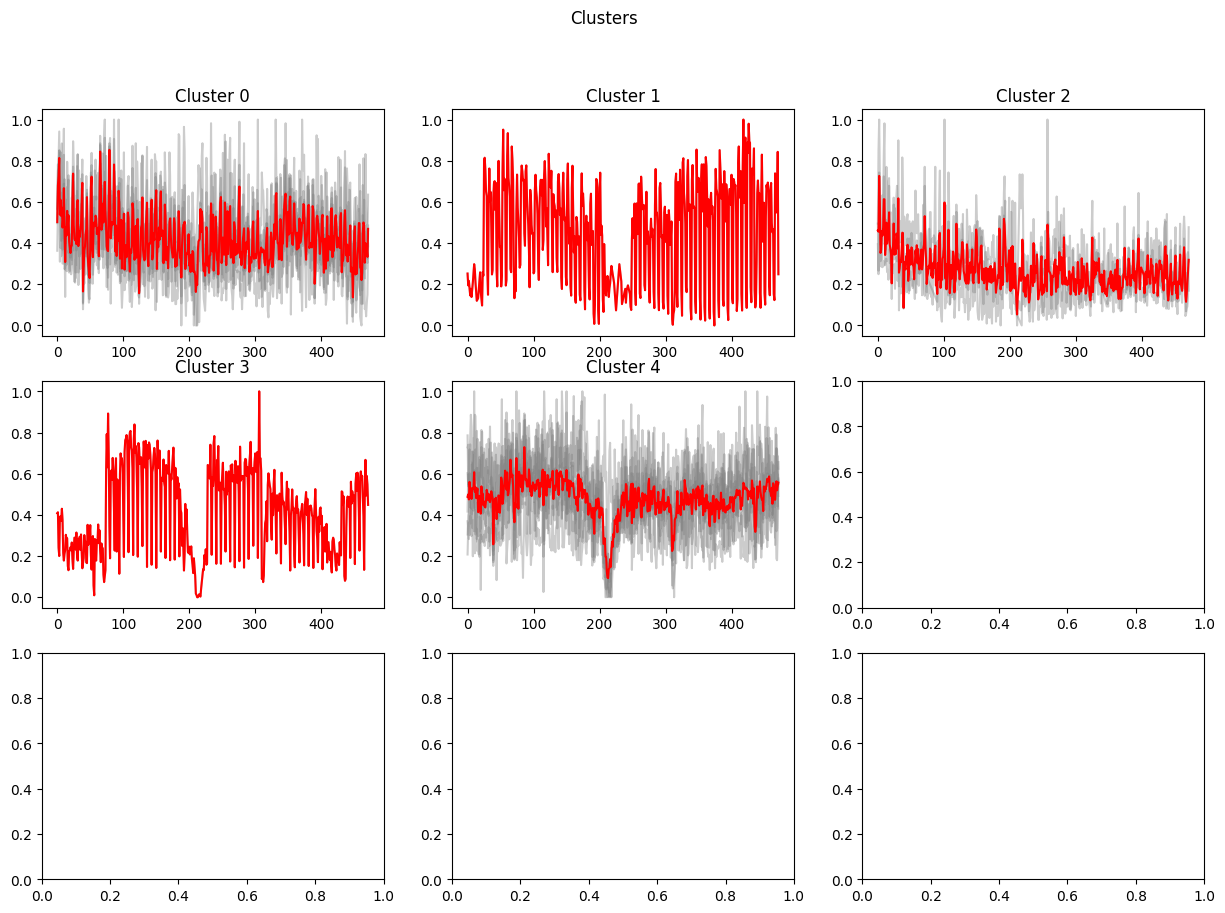

In [30]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(15,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*math.ceil(math.sqrt(math.sqrt(len(mySeries))))+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

As you can see from the plot, k-means clustered the 17 different series into 5 clusters. 2 of the clusters contains only 1 time series which may be deemed as an outlier. I use [DBA] to see much more time dilated series.

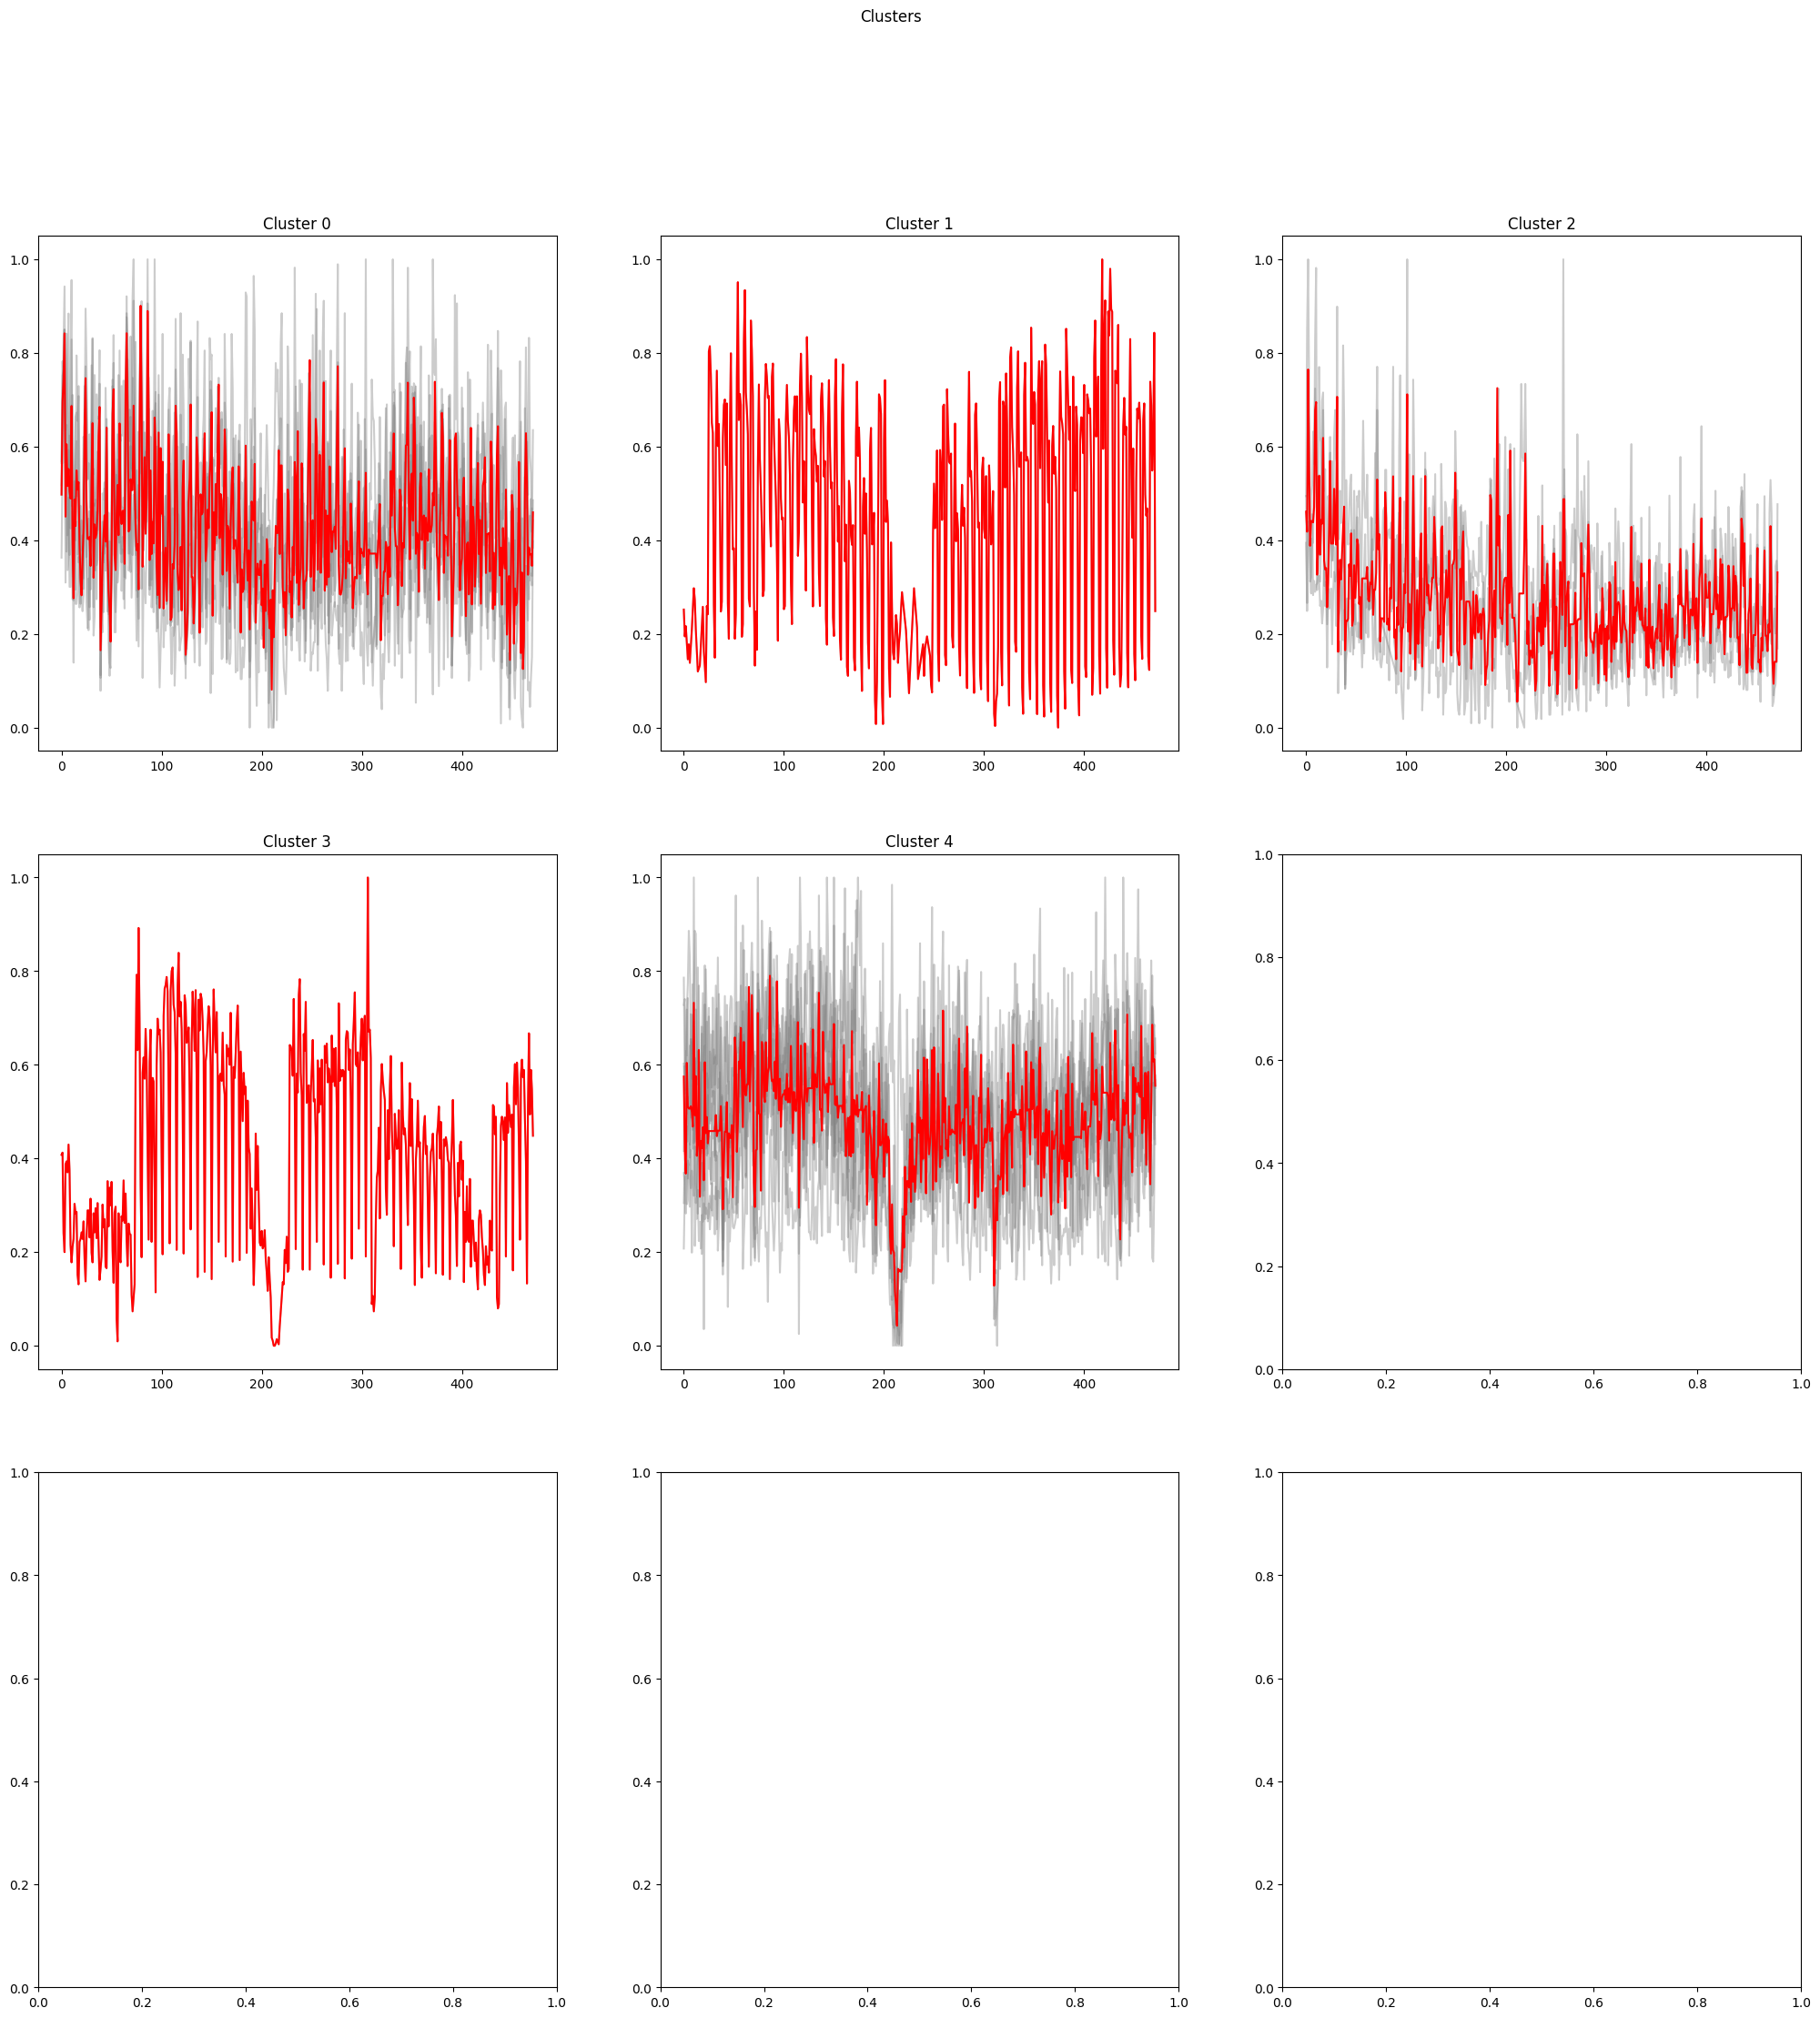

In [31]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0

# Lưu barycenter của các cụm
barycenters = []

for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
         
        cluster_array = np.vstack(cluster)  # Chuyển cluster thành mảng numpy
        barycenter = dtw_barycenter_averaging(cluster_array)
        barycenters.append(barycenter)  # Lưu barycenter
    
        axs[row_i, column_j].plot(barycenter,c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*math.ceil(math.sqrt(math.sqrt(len(mySeries))))+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

The next step is to save the strings that represent the clusters into their respective .csv files for forecasting purposes.

In [27]:
# import os
# import numpy as np

# # Tạo thư mục lưu trữ barycenters (nếu chưa tồn tại)
# output_dir = "barycenters_output"
# os.makedirs(output_dir, exist_ok=True)

# # Lưu barycenters ra file
# for i, barycenter in enumerate(barycenters):
#     # Định dạng tên file
#     file_name = os.path.join(output_dir, f"cluster_{i}_barycenter.csv")
    
#     # Lưu barycenter dưới dạng CSV
#     np.savetxt(file_name, barycenter, delimiter=",")
    
#     print(f"Barycenter for Cluster {i} saved to {file_name}")

# print(f"All barycenters have been saved to the '{output_dir}' directory.")


We can see the distribution of the time series in clusters in the following chart.

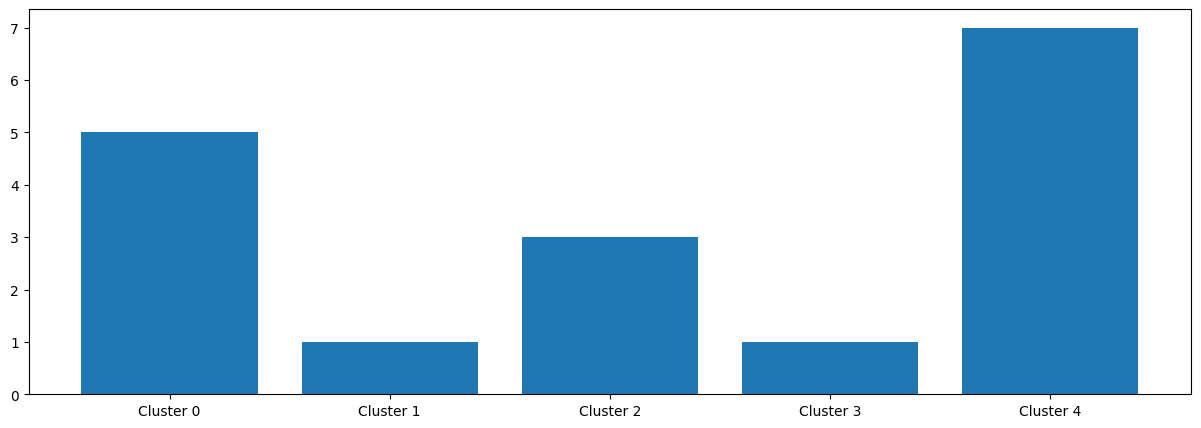

In [28]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
# plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In this part we will be finding which series belonging to which cluster. Thanks to awesome scikit-learn library we actually already have that information. Order of the labels is the same order with our series.

In [29]:
labels

array([4, 4, 0, 3, 2, 2, 4, 4, 0, 4, 0, 4, 0, 4, 1, 0, 2], dtype=int64)

In [30]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
aa_448,Cluster 0
aa_082,Cluster 0
aa_736,Cluster 0
aa_572,Cluster 0
aa_965,Cluster 0
aa_914,Cluster 1
aa_977,Cluster 2
aa_328,Cluster 2
aa_322,Cluster 2


# 3. References

- Petitjean F., Ketterlin A., Gançarski P., A global averaging method for dynamic time warping, with applications to clustering, Pattern Recognition, 44(3), 678-693, 2011
- Kohonen T., Self-organized formation of topologically correct feature maps, Biological Cybernetics, 43, 59–69, 1982
- Bellman R., Kalaba R., On adaptive control processes, in IRE Transactions on Automatic Control, 4(2), 1-9, 1959

# 4. See Also

* [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)